## 1.2: Importing Libraries

In [1]:
import pandas as pd
from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

## 2.1: Importing the Data

In [2]:
df = pd.read_csv("ratings.csv")

In [3]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


## 2.2 Dropping timestamp

In [4]:
df.drop(["timestamp"],axis=1, inplace=True)

In [5]:
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


## 2.3 Check for Missing Data

In [6]:
df.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

## 3.1 Number of movies/users

In [7]:
n_movies = df["movieId"].nunique()
n_users = df["userId"].nunique()

In [8]:
n_movies, n_users

(9724, 610)

## 3.2 Sparsity of our data

Sparsity (%) = `(No of missing values/ (Total Values))X100`

In [9]:
available_ratings = df["rating"].count()

total_ratings = n_movies * n_users

missing_ratings = total_ratings - available_ratings

In [10]:
sparsity = (missing_ratings/total_ratings) * 100

In [11]:
sparsity

98.30003169443864

## 3.3 Ratings Distribution

NameError: name 'plt' is not defined

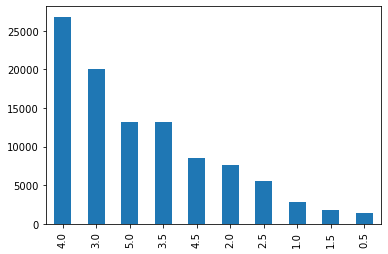

In [12]:
df["rating"].value_counts().plot(kind="bar")
plt.show()

## 4.1 Filter movies with less than 3 ratings

In [13]:
filter_movies = df["movieId"].value_counts() > 3

In [14]:
filter_movies = filter_movies[filter_movies].index.to_list()

## 4.2 Filter users with less than 3 movies rated

In [15]:
filter_users = df["userId"].value_counts() > 3

In [16]:
filter_users = filter_users[filter_users].index.to_list()

## 4.3 Remove rarely rated movies and rarely rating users

In [17]:
df = df[(df["movieId"].isin(filter_movies)) & (df["userId"].isin(filter_users))]

In [18]:
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100830,610,166528,4.0
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0


In [19]:
df.shape

(92394, 3)

## 5.1 Columns used for training

In [20]:
cols = ['userId','movieId','rating']

## 5.2 Create surprise dataset

In [21]:
reader = Reader(rating_scale= (0.5,5))

In [22]:
data = Dataset.load_from_df(df[cols], reader)

## 5.3 Create Train-set and Prediction-set

In [23]:
trainset = data.build_full_trainset()
antiset = trainset.build_anti_testset()

## 6.1 Creating the model

**SVD (Singular Value Decomposition)**

Interaction Matrix = A X B X C

In [24]:
algo = SVD(n_epochs=25, verbose=True)

## 6.2 Training the model

**Mean Absolute Error (MAE)**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. 

**Root mean squared error (RMSE)**:  RMSE is the square root of the average of squared differences between prediction and actual observation.

In [25]:
cross_validate(algo,data, measures=["RMSE","MAE"], cv=5, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

{'test_rmse': array([0.86535697, 0.86359784, 0.85784501, 0.86303142, 0.86065772]),
 'test_mae': array([0.66289875, 0.66180732, 0.65913242, 0.66441232, 0.65874432]),
 'fit_time': (6.758243083953857,
  7.189887762069702,
  7.131779909133911,
  7.170339345932007,
  7.604754686355591),
 'test_time': (0.19014739990234375,
  0.21007180213928223,
  0.25985169410705566,
  0.1862163543701172,
  0.34024620056152344)}

## 7.1 Predict ratings for all pairs (user, items) that are NOT in the training set.

In [26]:
predictions = algo.test(antiset)

In [27]:
predictions[0]

Prediction(uid=1, iid=318, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

## 7.2 Recommending top 3 movies movies based on predictions

In [28]:
from collections import defaultdict
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
top_n = get_top_n(predictions, n=3)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings])

1 [318, 1704, 899]
2 [541, 2571, 1237]
3 [2959, 318, 4993]
4 [3462, 3114, 3089]
5 [1204, 246, 2019]
6 [91529, 177593, 899]
7 [81847, 1036, 912]
8 [1196, 4993, 1201]
9 [1196, 296, 1204]
10 [908, 899, 1204]
11 [7153, 912, 1213]
12 [50, 356, 1089]
13 [750, 1222, 2858]
14 [541, 2571, 4973]
15 [1197, 2761, 912]
16 [56782, 1204, 3275]
17 [1204, 7361, 1219]
18 [899, 2160, 56782]
19 [4878, 1204, 4226]
20 [318, 1208, 4973]
21 [1204, 1223, 3836]
22 [1204, 50, 6016]
23 [1204, 56782, 951]
24 [899, 750, 1196]
25 [50, 356, 593]
26 [750, 2542, 1104]
27 [2542, 6942, 7153]
28 [2324, 951, 922]
29 [899, 5952, 2160]
30 [1208, 1219, 1617]
31 [318, 7371, 2329]
32 [7361, 6874, 4973]
33 [750, 1219, 1276]
34 [4011, 1213, 916]
35 [318, 2028, 56782]
36 [4973, 750, 899]
37 [912, 1213, 858]
38 [912, 922, 1270]
39 [1250, 6874, 1884]
40 [1225, 1258, 858]
41 [1673, 2542, 7371]
42 [2858, 79132, 111]
43 [50, 260, 527]
44 [318, 1209, 593]
45 [1089, 318, 106100]
46 [750, 6016, 2959]
47 [899, 903, 1213]
48 [56782, 527, 31